# 2. Amazon
## STEP 1 : 시계열 데이터 준비

In [4]:
import io
import sklearn
import statsmodels
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6 
import warnings
warnings.filterwarnings('ignore') 

In [5]:
dataset_filepath = os.getenv('HOME') + '/aiffel/my_data/AMZN.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2022-01-04    167.522003
2022-01-05    164.356995
2022-01-06    163.253998
2022-01-07    162.554001
2022-01-10    161.485992
Name: Close, dtype: float64

#### 클라우드 주피터에 csv 파일 업로드가 안돼서, colab에서 진행했다.  그러다 밑의 Auto-Arima 때문에 다시 클라우드로 옮겼다.   

REF)     
https://growthj.link/python-%EA%B5%AC%EA%B8%80-colab%EC%9C%BC%EB%A1%9C-pd-read-csv-%ED%99%9C%EC%9A%A9%ED%95%98%EB%8A%94-%EB%B0%A9%EB%B2%95/  colab으로 csv 파일 업로드   
https://blog.naver.com/nabilera1/222587254561 colab 마크다운 단축키

# STEP 2 : 각종 전처리 수행


In [6]:
# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

#### 결측치는 없다. 

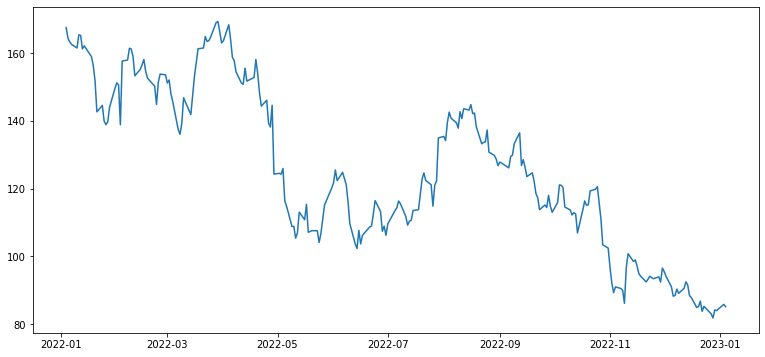

In [7]:
plt.plot(ts)

#### 주가가 1년 새에 반토막이 됐다. 

In [8]:
# 로그 변환
ts_log = np.log(ts)
ts_log

Date
2022-01-04    5.121115
2022-01-05    5.102041
2022-01-06    5.095307
2022-01-07    5.091010
2022-01-10    5.084418
                ...   
2022-12-28    4.404522
2022-12-29    4.432957
2022-12-30    4.430817
2023-01-03    4.452252
2023-01-04    4.444297
Name: Close, Length: 252, dtype: float64

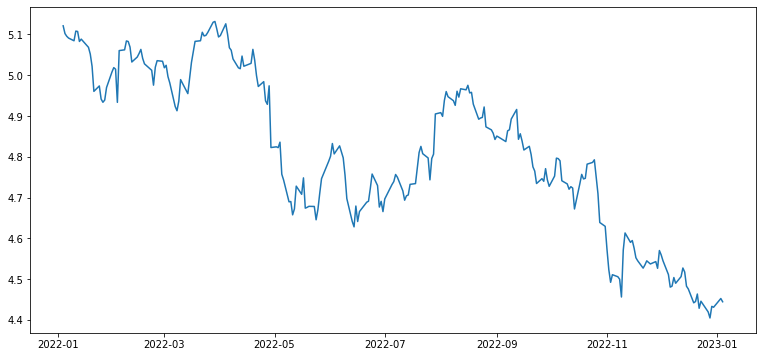

In [9]:
plt.plot(ts_log)

## STEP 3 : 시계열 안정성 분석

In [10]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
print('주식왕이 될 준비 3단계 완료!')

주식왕이 될 준비 3단계 완료!


In [11]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
print('주식왕이 될 준비 4단계 완료!')

주식왕이 될 준비 4단계 완료!


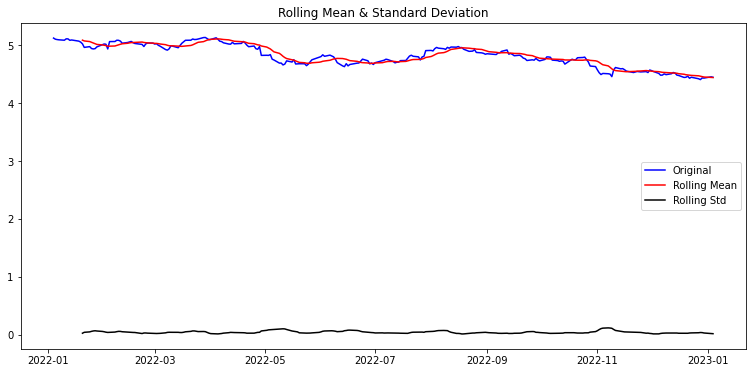

Results of Dickey-Fuller Test:
Test Statistic                  -1.061477
p-value                          0.730187
#Lags Used                       0.000000
Number of Observations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -2.572944
dtype: float64


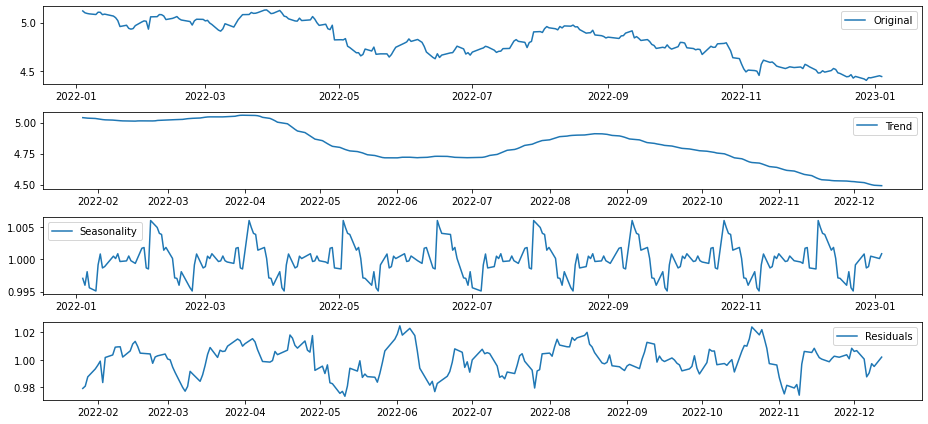

In [12]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 원본(로그변환한) - 추세 - 계절성

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()


#### p-value 값이 0.7로 꽤 높다. 귀무가설이 맞는 쪽에 가깝다. 

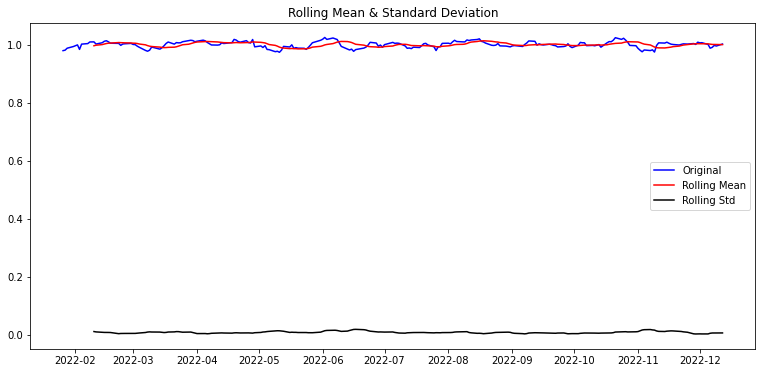

In [13]:
plot_rolling_statistics(residual)

In [14]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -5.427553
p-value                          0.000003
#Lags Used                       2.000000
Number of Observations Used    219.000000
Critical Value (1%)             -3.460567
Critical Value (5%)             -2.874830
Critical Value (10%)            -2.573853
dtype: float64


#### Residual의 p-value가 0.000003으로 꽤 작다   
    
    

## STEP 4 : 학습, 테스트 데이터셋 생성

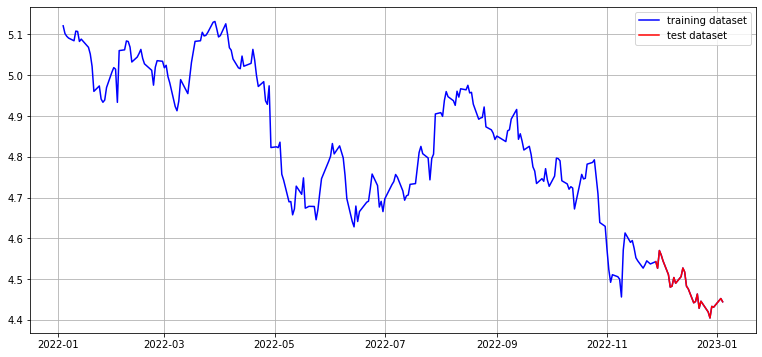

In [15]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure()
plt.grid(True)
plt.plot(ts_log, c='b', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='r', label='test dataset')
plt.legend()

## STEP 5 : 적정 ARIMA 모수 찾기

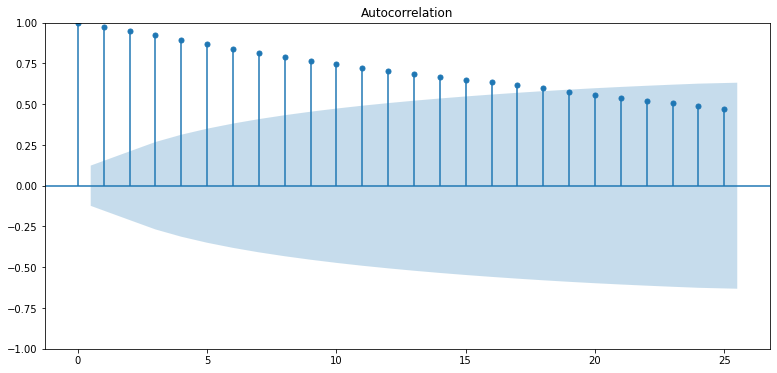

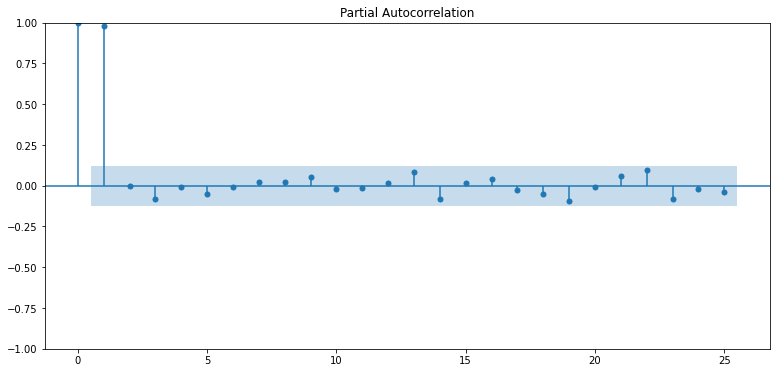

In [16]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   
plot_pacf(ts_log) 
plt.show()

#### ACF는 완만하게 감소하기 때문에 q=0이 적합하다. 
#### PACF는 lag 1이 유의미하다. p=1이 적합하다. 
#### colab에서는 오히려 AttributeError: 'Line2D' object has no property 'auto_ylims' 이런 에러가 나와 auto_ylims= True를 없애주었다. 

Results of Dickey-Fuller Test:
Test Statistic                -1.571629e+01
p-value                        1.340598e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.500000e+02
Critical Value (1%)           -3.456781e+00
Critical Value (5%)           -2.873172e+00
Critical Value (10%)          -2.572969e+00
dtype: float64


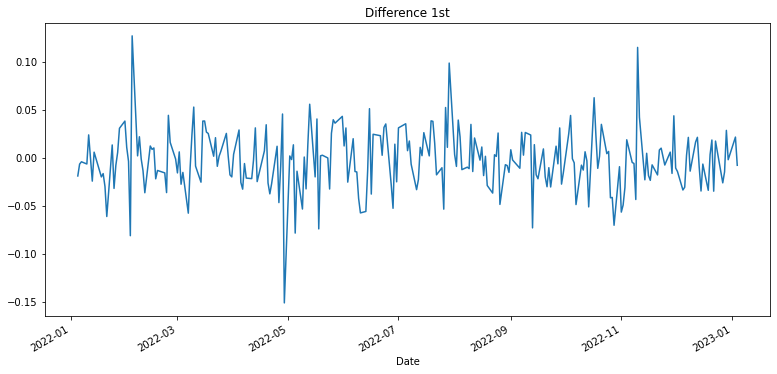

In [17]:
# 차분 안정성 확인 -> d 구하기
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

#### 1차 차분으로 p-value가 많이 낮아졌다. 

Results of Dickey-Fuller Test:
Test Statistic                -8.553420e+00
p-value                        9.093374e-14
#Lags Used                     1.100000e+01
Number of Observations Used    2.380000e+02
Critical Value (1%)           -3.458128e+00
Critical Value (5%)           -2.873762e+00
Critical Value (10%)          -2.573283e+00
dtype: float64


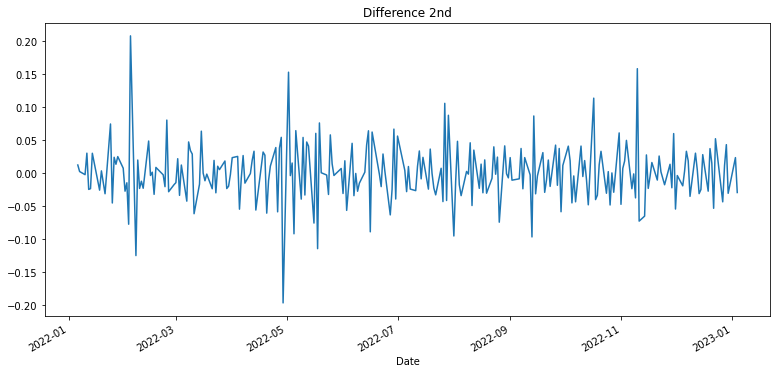

In [18]:
# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

#### 2차 차분보다 1차 차분에서 p-value 값이 낮다. d=1이 적합하다. 

## STEP 6 : ARIMA 모델 훈련과 테스트

In [19]:
from statsmodels.tsa.arima.model import ARIMA
model1 = ARIMA(train_data, order=(0,1,0))
model2 = ARIMA(train_data, order=(0,1,1))
model3 = ARIMA(train_data, order=(1,1,0))

res1 = model1.fit()
res2 = model2.fit()
res3 = model3.fit()

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequenc

In [20]:
res1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  226
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 451.389
Date:                Fri, 06 Jan 2023   AIC                           -900.777
Time:                        03:45:58   BIC                           -897.361
Sample:                             0   HQIC                          -899.399
                                - 226                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0011   6.41e-05     16.521      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                78.07
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               1.05   Skew:                            -0.01
Prob(H) (two-sided):                  0.82   Kurtosis:                         5.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [21]:
res2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  226
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 451.412
Date:                Fri, 06 Jan 2023   AIC                           -898.824
Time:                        03:45:58   BIC                           -891.991
Sample:                             0   HQIC                          -896.066
                                - 226                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0142      0.069      0.206      0.837      -0.121       0.150
sigma2         0.0011   7.64e-05     13.852      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                82.64
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               1.05   Skew:                            -0.01
Prob(H) (two-sided):                  0.83   Kurtosis:                         5.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [22]:
res3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  226
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 451.416
Date:                Fri, 06 Jan 2023   AIC                           -898.831
Time:                        03:45:58   BIC                           -891.999
Sample:                             0   HQIC                          -896.074
                                - 226                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0155      0.069      0.226      0.822      -0.119       0.150
sigma2         0.0011   7.62e-05     13.896      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                83.06
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               1.05   Skew:                            -0.01
Prob(H) (two-sided):                  0.83   Kurtosis:                         5.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### ACF, PACF, 차분을 통해서 구한 값을 넣은 model3보다 model1의 AIC가 더 낮게 나온다. 최적의 파라미터가 꼭 그래프에 비례하지는 않은 것 같다. 

In [23]:
fc1 = res1.forecast(len(test_data), alpha=0.05)
fc2 = res2.forecast(len(test_data), alpha=0.05)
fc3 = res3.forecast(len(test_data), alpha=0.05) 

fc1 = np.array(fc1)
fc2 = np.array(fc2)
fc3 = np.array(fc3)

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


In [24]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math 

mape1 = np.mean(np.abs(np.exp(fc1) - np.exp(test_data))/np.abs(np.exp(test_data)))
mape2 = np.mean(np.abs(np.exp(fc2) - np.exp(test_data))/np.abs(np.exp(test_data)))
mape3 = np.mean(np.abs(np.exp(fc3) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('(0,1,0)일 때 MAPE: {:.2f}%'.format(mape1*100))
print('(0,1,1)일 때 MAPE: {:.2f}%'.format(mape2*100))
print('(1,1,0)일 때 MAPE: {:.2f}%'.format(mape3*100))

(0,1,0)일 때 MAPE: 6.31%
(0,1,1)일 때 MAPE: 6.30%
(1,1,0)일 때 MAPE: 6.30%


#### AIC는 model1이 가장 낮게 나왔지만, MAPE는 model2, 3가 더 낮다. 

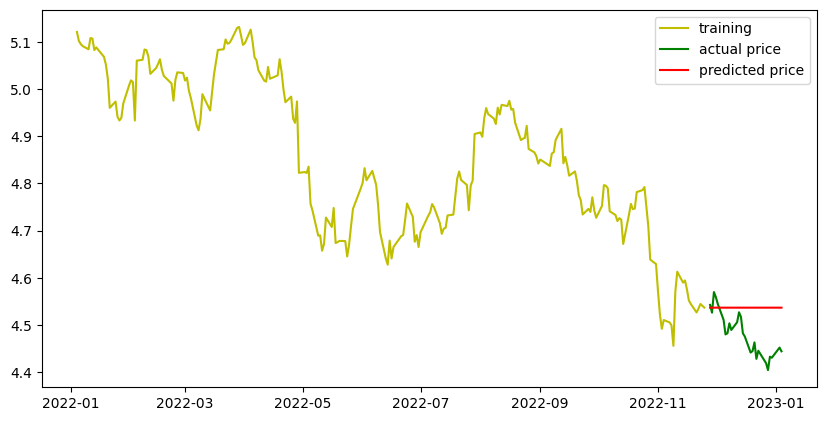

In [25]:
# Make as pandas series
fc3_series = pd.Series(fc3, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, c='y',label='training')
plt.plot(test_data, c='g', label='actual price')
plt.plot(fc3_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [26]:
print('(1,1,0)일 때')
mse = mean_squared_error(np.exp(test_data), np.exp(fc2))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc2))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc2)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc3) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

(1,1,0)일 때
MSE:  40.4026434207292
MAE:  5.418588949851078
RMSE:  6.3563073730531
MAPE: 6.30%


#### MAPE 값은 15% 이하가 나왔지만, 그래프 상으로는 거의 예측하지 못했다. 1차 차분으로 다시 ACF, PACF 그래프에서 더 적합한 p, q값을 찾아야겠다. 

[]

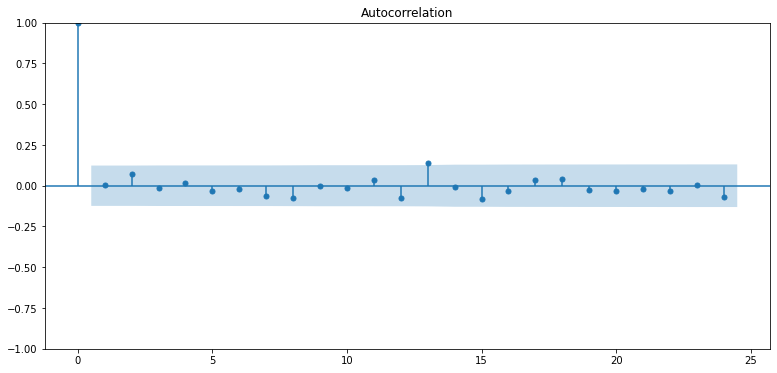

In [27]:
plot_acf(diff_1)
plt.plot()

#### 차분을 한 후 acf에서 그다지 유의미한 lag가 없다. q=0이나 13이 적합하다. 

[]

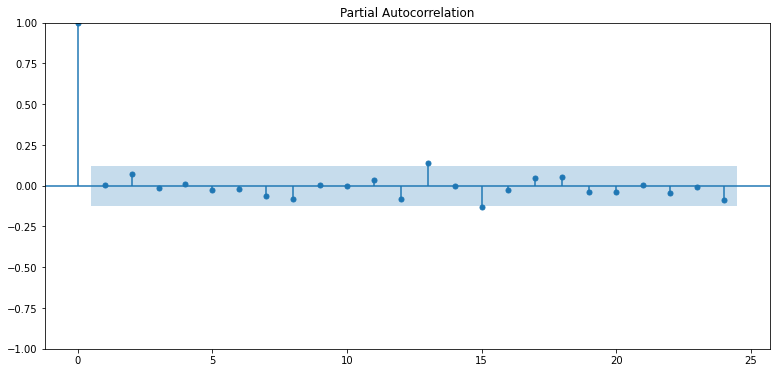

In [28]:
plot_pacf(diff_1)
plt.plot()

#### PACF에서도 유의미한 lag가 없다. p=0이나 13이 적합하다. 

In [30]:
import pmdarima as pm #오토 아리마
model = pm.AutoARIMA(seasonal = True, suppress_warnings = True, trace = True, max_D = 12)
res = model.fit(train_data)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-893.760, Time=0.68 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-900.214, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-898.234, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-898.231, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-900.777, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-896.239, Time=0.17 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.221 seconds


#### colab에는 Auto-ARIMA가 안 깔려있어서, 퍼실님들 도움으로 에러를 해결하고  설치했다. 
#### Auto-ARIMA를 돌려도 (0, 1, 0)을 추천해준다. 위에서 이미 MAPE 값을 확인한 파라미터이므로, MAPE 6.30% 이하로 낮출 수는 없을 것 같다. 
REF)    
https://stackoverflow.com/questions/59004118/how-can-i-install-pmdarima 오토아리마 설치

# 3. The Coca-Cola Company
## STEP 1 : 시계열 데이터 준비

In [36]:
from google.colab import files
myfile = files.upload()

Saving KO.csv to KO.csv


In [38]:
#pd.read_csv로 csv파일 불러오기
data = pd.read_csv(io.BytesIO(myfile['KO.csv']), index_col='Date', parse_dates=True)
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-01-05,60.090000,61.200001,60.049999,60.790001,59.043186,22507300
2022-01-06,60.470001,61.119999,60.439999,60.470001,58.732388,17902300
2022-01-07,60.279999,60.720001,60.060001,60.330002,58.596409,12307900
2022-01-10,60.549999,60.820000,60.180000,60.430000,58.693531,20954300
2022-01-11,60.430000,60.490002,59.840000,60.450001,58.712959,19369600


In [39]:
ts = data['Close']
ts.head()

Date
2022-01-05    60.790001
2022-01-06    60.470001
2022-01-07    60.330002
2022-01-10    60.430000
2022-01-11    60.450001
Name: Close, dtype: float64

# STEP 2 : 각종 전처리 수행

In [40]:
ts = ts.interpolate(method='time')
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

#### 결측치는 없다. 

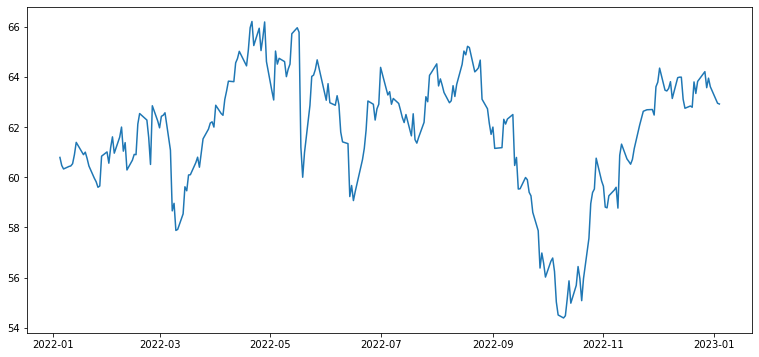

In [41]:
plt.plot(ts)

In [42]:
# 로그 변환
ts_log = np.log(ts)
ts_log

Date
2022-01-05    4.107425
2022-01-06    4.102147
2022-01-07    4.099830
2022-01-10    4.101486
2022-01-11    4.101817
                ...   
2022-12-28    4.152142
2022-12-29    4.158102
2022-12-30    4.152771
2023-01-03    4.142341
2023-01-04    4.141864
Name: Close, Length: 251, dtype: float64

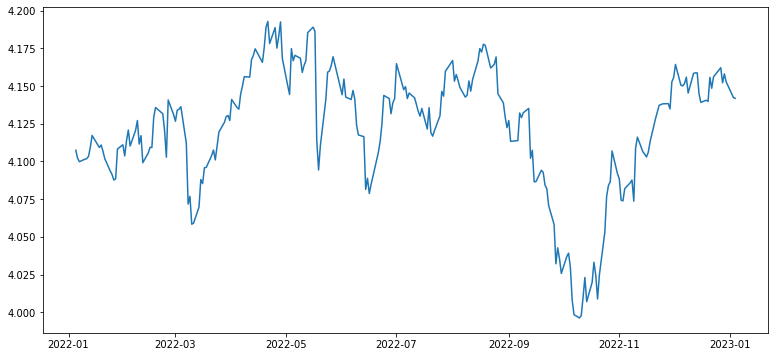

In [43]:
plt.plot(ts_log)

## STEP 3 : 시계열 안정성 분석

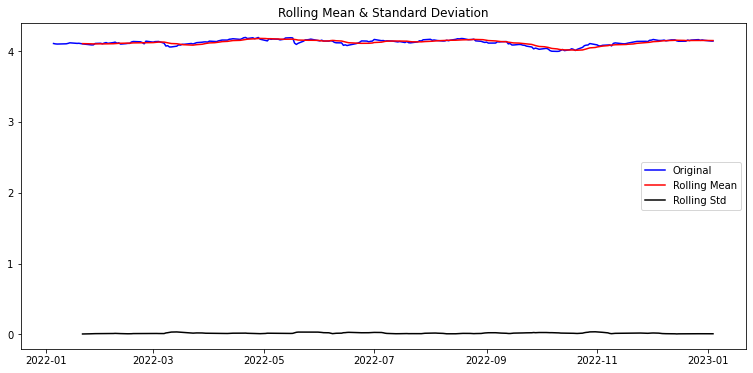

Results of Dickey-Fuller Test:
Test Statistic                  -2.378460
p-value                          0.147908
#Lags Used                       0.000000
Number of Observations Used    250.000000
Critical Value (1%)             -3.456781
Critical Value (5%)             -2.873172
Critical Value (10%)            -2.572969
dtype: float64


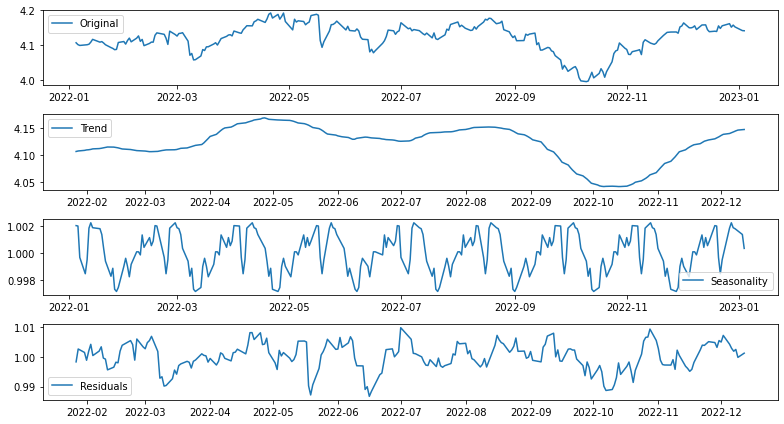

In [44]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 원본(로그변환한) - 추세 - 계절성

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()


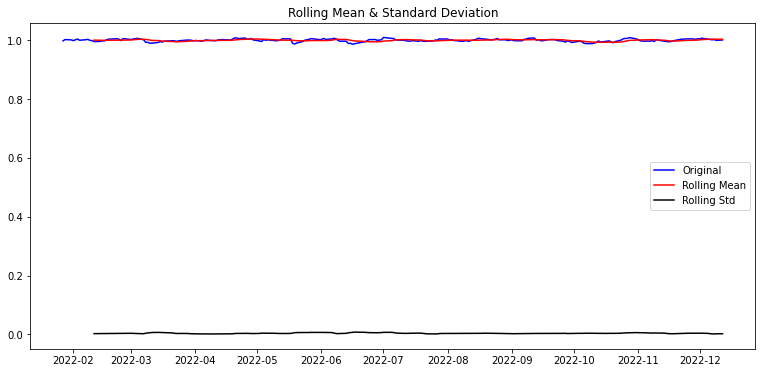

In [45]:
plt.rcParams["figure.figsize"] = (13,6)
plot_rolling_statistics(residual)

In [46]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -5.703127e+00
p-value                        7.594911e-07
#Lags Used                     2.000000e+00
Number of Observations Used    2.180000e+02
Critical Value (1%)           -3.460708e+00
Critical Value (5%)           -2.874891e+00
Critical Value (10%)          -2.573886e+00
dtype: float64


#### 시계열 분해 후 얻은 Residual의 p-value은 7.594911e-07로 매우 낮다. 시계열이 안정된 것을 확인할 수 있다. 

## STEP 4 : 학습, 테스트 데이터셋 생성

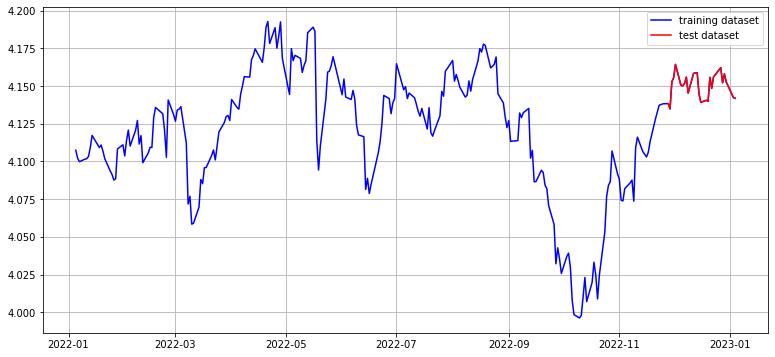

In [47]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure()
plt.grid(True)
plt.plot(ts_log, c='b', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='r', label='test dataset')
plt.legend()

## STEP 5 : 적정 ARIMA 모수 찾기

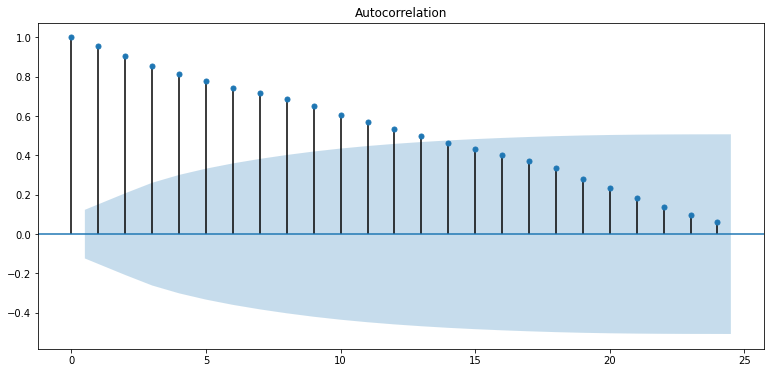

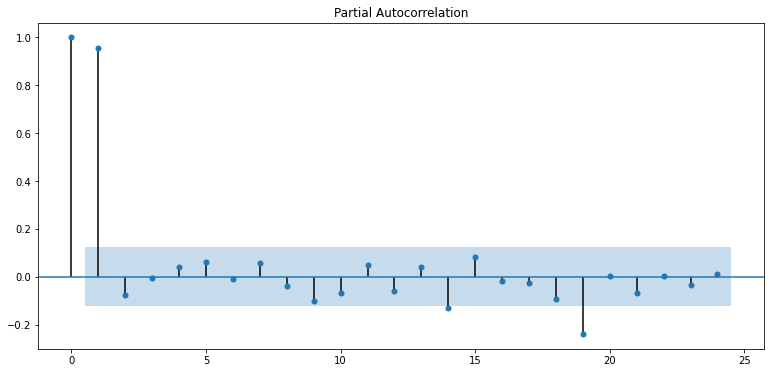

In [49]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings('ignore') 

plot_acf(ts_log)   
plot_pacf(ts_log) 
plt.show()

#### ACF는 완만하게 감소하기 때문에 q=0이 적합하다. 
#### PACF는 lag 1이 유의미하다. p=1이 적합하다. 

Results of Dickey-Fuller Test:
Test Statistic                -1.503111e+01
p-value                        9.899727e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.490000e+02
Critical Value (1%)           -3.456888e+00
Critical Value (5%)           -2.873219e+00
Critical Value (10%)          -2.572994e+00
dtype: float64


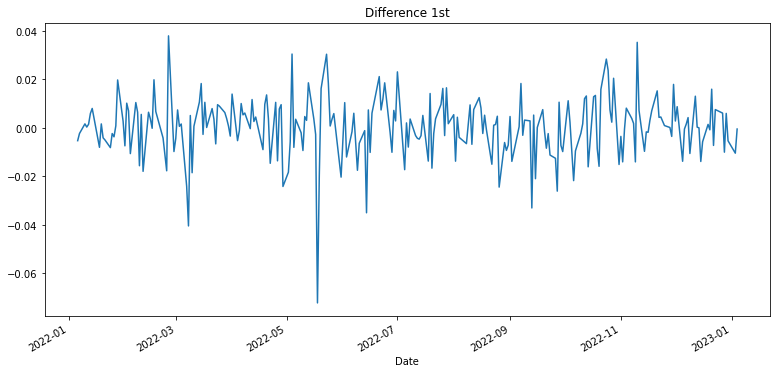

In [50]:
# 차분 안정성 확인 -> d 구하기
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -7.658377e+00
p-value                        1.714651e-11
#Lags Used                     1.600000e+01
Number of Observations Used    2.320000e+02
Critical Value (1%)           -3.458855e+00
Critical Value (5%)           -2.874080e+00
Critical Value (10%)          -2.573453e+00
dtype: float64


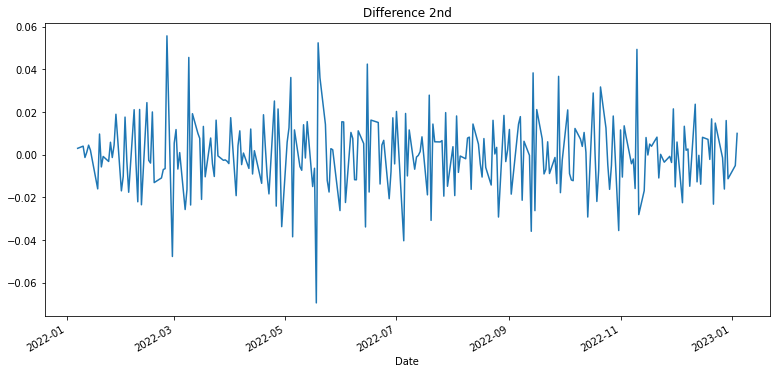

In [51]:
# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

#### 2차 차분보다 1차 차분의 p-value 값이 더 작다. d=1이 적합하다.     

## STEP 6 : ARIMA 모델 훈련과 테스트

In [52]:
from statsmodels.tsa.arima.model import ARIMA
model1 = ARIMA(train_data, order=(0,0,0))
model2 = ARIMA(train_data, order=(0,1,0))
model3 = ARIMA(train_data, order=(1,1,0))
model4 = ARIMA(train_data, order=(19,1,0))

res1 = model1.fit()
res2 = model2.fit()
res3 = model3.fit()
res4 = model4.fit()

In [53]:
res1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  225
Model:                          ARIMA   Log Likelihood                 392.027
Date:                Fri, 06 Jan 2023   AIC                           -780.054
Time:                        01:32:22   BIC                           -773.222
Sample:                             0   HQIC                          -777.296
                                - 225                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.1182      0.003   1266.263      0.000       4.112       4.125
sigma2         0.0018      0.000     10.212      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                 207.37   Jarque-Bera (JB):                24.64
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               4.09   Skew:                            -0.78
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [54]:
res2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 657.740
Date:                Fri, 06 Jan 2023   AIC                          -1313.480
Time:                        01:32:31   BIC                          -1310.068
Sample:                             0   HQIC                         -1312.102
                                - 225                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0002   8.71e-06     18.906      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.79   Jarque-Bera (JB):               207.51
Prob(Q):                              0.38   Prob(JB):                         0.00
Heteroskedasticity (H):               1.26   Skew:                            -0.83
Prob(H) (two-sided):                  0.33   Kurtosis:                         7.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [55]:
res3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 658.129
Date:                Fri, 06 Jan 2023   AIC                          -1312.258
Time:                        01:32:36   BIC                          -1305.435
Sample:                             0   HQIC                         -1309.504
                                - 225                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0590      0.064      0.921      0.357      -0.067       0.185
sigma2         0.0002   8.74e-06     18.785      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               203.97
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.24   Skew:                            -0.82
Prob(H) (two-sided):                  0.36   Kurtosis:                         7.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [56]:
res4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  225
Model:                ARIMA(19, 1, 0)   Log Likelihood                 667.626
Date:                Fri, 06 Jan 2023   AIC                          -1295.251
Time:                        01:32:43   BIC                          -1227.018
Sample:                             0   HQIC                         -1267.709
                                - 225                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0677      0.068      0.993      0.321      -0.066       0.201
ar.L2         -0.0484      0.070     -0.689      0.491      -0.186       0.089
ar.L3         -0.0306      0.073     -0.420      0.674      -0.173       0.112
ar.L4         -0.0683      0.074     -0.923      0.356      -0.213       0.077
ar.L5         -0.0160      0.079     -0.204      0.838      -0.170       0.138
ar.L6         -0.0618      0.073     -0.847      0.397      -0.205       0.081
ar.L7          0.0294      0.064      0.459      0.646      -0.096       0.155
ar.L8          0.0444      0.073      0.612      0.540      -0.098       0.187
ar.L9          0.0435      0.080      0.545      0.585      -0.113       0.200
ar.L10        -0.0800      0.073     -1.096      0.273      -0.223       0.063
ar.L11         0.0444      0.070      0.634      0.526      -0.093       0.181
ar.L12        -0.0703      0.073     -0.966      0.334      -0.213       0.072
ar.L13         0.0863      0.076      1.137      0.256      -0.062       0.235
ar.L14        -0.0859      0.078     -1.100      0.271      -0.239       0.067
ar.L15        -0.0139      0.069     -0.203      0.839      -0.149       0.121
ar.L16         0.0293      0.085      0.345      0.730      -0.137       0.196
ar.L17         0.0305      0.089      0.344      0.731      -0.143       0.204
ar.L18         0.1765      0.068      2.601      0.009       0.044       0.310
ar.L19        -0.0284      0.076     -0.376      0.707      -0.176       0.120
sigma2         0.0002   1.37e-05     10.982      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               103.17
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.14   Skew:                            -0.61
Prob(H) (two-sided):                  0.58   Kurtosis:                         6.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### ACF, PACF, 차분을 통해 예측한 model3보다 model2의 AIC가 가장 낮다. 

In [57]:
# Forecast : 결과가 fc에 담깁니다.
fc1 = res1.forecast(len(test_data), alpha=0.05)
fc2 = res2.forecast(len(test_data), alpha=0.05)
fc3 = res3.forecast(len(test_data), alpha=0.05) 
fc4 = res4.forecast(len(test_data), alpha=0.05) 

fc1 = np.array(fc1)
fc2 = np.array(fc2)
fc3 = np.array(fc3)
fc4 = np.array(fc4)

In [58]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math 

mape1 = np.mean(np.abs(np.exp(fc1) - np.exp(test_data))/np.abs(np.exp(test_data)))
mape2 = np.mean(np.abs(np.exp(fc2) - np.exp(test_data))/np.abs(np.exp(test_data)))
mape3 = np.mean(np.abs(np.exp(fc3) - np.exp(test_data))/np.abs(np.exp(test_data)))
mape4 = np.mean(np.abs(np.exp(fc4) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('(0,0,0)일 때 MAPE: {:.2f}%'.format(mape1*100))
print('(0,1,0)일 때 MAPE: {:.2f}%'.format(mape2*100))
print('(1,1,0)일 때 MAPE: {:.2f}%'.format(mape3*100))
print('(19,1,0)일 때 MAPE: {:.2f}%'.format(mape4*100))

(0,0,0)일 때 MAPE: 3.16%
(0,1,0)일 때 MAPE: 1.23%
(1,1,0)일 때 MAPE: 1.23%
(19,1,0)일 때 MAPE: 1.20%


#### AIC와 MAPE가 비례하지 않는다. AIC가 높게 나왔던 model4가 MAPE는 가장 낮게 나왔다. 

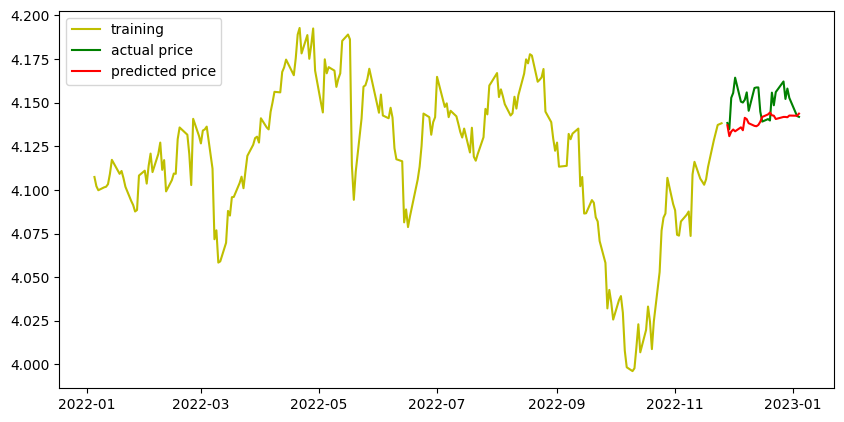

In [59]:
# Make as pandas series
fc4_series = pd.Series(fc4, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, c='y',label='training')
plt.plot(test_data, c='g', label='actual price')
plt.plot(fc4_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [60]:
print('(19,1,0)일 때')
mse = mean_squared_error(np.exp(test_data), np.exp(fc4))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc4))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc4)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc4) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

(19,1,0)일 때
MSE:  0.8420244768041838
MAE:  0.7647093564020402
RMSE:  0.917618916982526
MAPE: 1.20%


#### mape값이 낮게 나와서 그런지, 그래프도 꽤 예측을 잘했다.     



## 회고 

#### 헤맸던 것
- lms 클라우드에 두 회사의 csv 파일이 도저히 안 올라가, 로컬에서 vs code를 시도했다.
- vs code에서 csv 파일 불러올때도 문제가 생겨 colab으로 옮겨왔다. 
- colab에서도 드라이브에서 파일을 불러오려다 실패해 직접 업로드하느라 시간이 많이 들었다. 
- 아마존 데이터의 mape를 낮춰보고 싶어서 auto-arima를 설치해보았다. 
- colab에는 auto-arima 설치를 직접해야하는데, 에러가 생겨 구글링하는데 시간이 많이 들었다. 퍼실님께 여쭤보고 해결되었다. 

#### 새롭게 알게된 것
- acf, pacf에서 가장 높은 lag가 꼭 aic가 가장 낮게 나오지는 않는다.
- 반대로 aic가 가장 낮은 모델이 mape가 가장 낮게 나오지도 않는다. 
- 파라미터를 여러개 넣어서 mape를 비교해보는게 낫다.  
- vs code에서는 가상환경을 activate해야한다. 
- vs code에서 로컬 파일 불러오는 방법 

#### 아직도 모르는 것
- colab에서 구글 드라이브 파일 불러오는 방법